In [26]:
import meshio
import numpy as np
import scipy.sparse as ss
import scipy.sparse.linalg as ssla
from scipy.linalg import block_diag
import matplotlib.pyplot as plt

Read mesh

In [4]:
#case_folder = './4x2x3_el/'
#case_folder = './10x4x5_el/'
case_folder = './10x10x12_hex20/'

In [5]:
mesh = meshio.read(case_folder+'modal_mat.rmed','med')

Show numeric labels of mesh points

In [6]:
#mesh.point_data

Show Tags of mesh points: **R1** and **R2** have been used to define the interface sections

In [7]:
mesh.point_tags

{1: ['R1'], 2: ['R2']}

In [8]:
# get values(i.e. dictionary keys labeled 'R1' or 'R2'
for k in mesh.point_tags:
    if mesh.point_tags[k][0] == 'R1':
        r1_tag_value = k
    elif mesh.point_tags[k][0] == 'R2':
        r2_tag_value = k

### Generate index arrays for L and R sets

In [9]:
#indexes are related to points

#get point indexes belonging to R1
r1_set_point = mesh.point_data['point_tags'] == r1_tag_value

#make array of indexes where points belong to R1
r1_set_point_ix = np.where(r1_set_point)[0]

#get point indexes belonging to R2
r2_set_point = mesh.point_data['point_tags'] == r2_tag_value

#make array of indexes where points belong to R2
r2_set_point_ix = np.where(r2_set_point)[0]

#get point indexes belonging to R set (R1 or R2)
r_set_point = np.logical_or(r1_set_point, r2_set_point)

#get point indexes belonging to L set not (R1 or R2)
l_set_point = np.logical_not(r_set_point)

#repeat each value 3 times for coordinates
r1_set = np.repeat(r1_set_point,3)
r2_set = np.repeat(r2_set_point,3)
r_set  = np.repeat(r_set_point,3)
l_set  = np.repeat(l_set_point,3)

In [10]:
# make array of indexes where coordinates belong to r1 set
r1_set_ix = np.where(r1_set)[0]

# make array of indexes where coordinates belong to r2 set
r2_set_ix = np.where(r2_set)[0]

# make array of indexes where coordinates belong to r set
# r_set_ix = np.where(r_set)[0]
r_set_ix = np.concatenate((r1_set_ix, r2_set_ix))

# make array of indexes where coordinates belong to l set
l_set_ix = np.where(l_set)[0]

In [11]:
print(r1_set_ix)
print(r2_set_ix)
print(r_set_ix)

[   0    1    2 ... 5754 5755 5756]
[  12   13   14 ... 6408 6409 6410]
[   0    1    2 ... 6408 6409 6410]


In [12]:
# count size of coordinates belonging to r1 set
r1_set_num = np.sum(r1_set)

# count size of coordinates belonging to r2 set
r2_set_num = np.sum(r2_set)

# count size of coordinates belonging to r set
r_set_num = np.sum(r_set)

# count size of coordinates belonging to l set
l_set_num = np.sum(l_set)

Generate $\Phi_L$: read modal computation results

In [13]:
mesh_res = meshio.read(case_folder+'modal_mat.rmed','med')

In [14]:
mesh_res.point_data.keys()

dict_keys(['point_tags', 'modes___DEPL[0] - 2457.54', 'modes___DEPL[1] - 2620.74', 'modes___DEPL[2] - 2964.58', 'modes___DEPL[3] - 4956.02', 'modes___DEPL[4] - 5128.08', 'modes___DEPL[5] - 5191.67', 'modes___DEPL[6] - 5918.93', 'modes___DEPL[7] - 7912.47', 'modes___DEPL[8] - 8190.03', 'modes___DEPL[9] - 8453.18'])

extract $\omega^2$ vector and $\Phi_L$

In [16]:
omega2 = []

num_modes = 10

mode_keys = list(mesh_res.point_data.keys())
phi_l = np.zeros((l_set_num,num_modes))
    
k=0

while k<num_modes:
    result = [i for i in mode_keys if i.startswith('modes___DEPL['+str(k)+']')]
    if result:
        #print(result)
        curr_f = float(result[0].split(' ')[-1])
        #print(curr_f)
        omega2.append((2*np.pi*curr_f)**2)
        curr_mode = np.ravel(mesh_res.point_data[result[0]],'C')[l_set]
        phi_l[:,k] = curr_mode
    else:
        break
    k+=1



In [17]:
#phi_l

Read **mass** and **stiffness** matrices generated by *FEM*

In [18]:
M_tot = ss.load_npz(case_folder+'Mass.npz')
K_tot = ss.load_npz(case_folder+'Stiff.npz')
#M_tot = M_csr.todense()
#K_tot = K_csr.todense()
#with np.load(case_folder+'Mass.npz') as Mass:
#    print(Mass)
#K_tot = np.load(case_folder+'Stiff.npz')
#M_tot.values()

### Slice **mass** and **stiffness** matrices

*mass matrix*:

In [19]:
#M_RR_row = M_tot[r_set,:]
M_RR = M_tot[np.ix_(r_set_ix,r_set_ix)]

print(M_RR.shape)

#M_LL_row = M_tot[l_set,:]
M_LL = M_tot[np.ix_(l_set_ix,l_set_ix)]

print(M_LL.shape)

#M_RL_row = M_tot[r_set,:]
M_RL = M_tot[np.ix_(r_set_ix,l_set_ix)]

print(M_RL.shape)

#M_LR_row = M_tot[l_set,:]
M_LR = M_tot[np.ix_(l_set_ix,r_set_ix)]

print(M_LR.shape)

(2430, 2430)
(15225, 15225)
(2430, 15225)
(15225, 2430)


Slice *stiffness matrix*

In [20]:
K_RR = K_tot[np.ix_(r_set_ix,r_set_ix)]
print(K_RR.shape)

K_LL = K_tot[np.ix_(l_set_ix,l_set_ix)]
print(K_LL.shape)

K_RL = K_tot[np.ix_(r_set_ix,l_set_ix)]
print(K_RL.shape)

K_LR = K_tot[np.ix_(l_set_ix,r_set_ix)]
print(K_LR.shape)

(2430, 2430)
(15225, 15225)
(2430, 15225)
(15225, 2430)


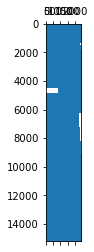

In [30]:
plt.spy(K_LR)

In [34]:
phi_r = ssla.bicgstab(K_LL,K_LR.todense()[:,0])

Compute $\Phi_R$ from sliced matrices:
$$\Phi_R = - K_{LL}^{-1} \cdot K_{LR}$$

In [18]:
phi_r = -ssla.spsolve(K_LL.tocsc(),K_LR.tocsc())

Compute reduced matrices ($M_{BB}$ and $K_{BB}$) as for *Craig - Bampton* (cfr. eq. 1.14 and 1.15):

$$M_r = \begin{bmatrix} M_{RR} + M_{RL}\cdot \Phi_R + \Phi_R^T \cdot (M_{LR} + M_{LL}\cdot \Phi_R) & M_{RL}\cdot \Phi_L + \Phi_R^T \cdot M_{LL} \cdot \Phi_L \\
\Phi_L^T \cdot (M_{LR} + M_{LL} \cdot \Phi_R) & \Phi_L^T \cdot M_{LL} \cdot \Phi_L
\end{bmatrix}$$

with $M_{RL} \cdot \Phi_R = M_{RL}\Phi_R$ and $ \Phi_R^T \cdot M_{LR} = (M_{RL}\Phi_R)^T$

$$M_r = \begin{bmatrix} M_{RR} + M_{RL}\Phi_R + (M_{RL}\Phi_R)^T  + \Phi_R^T \cdot M_{LL}\cdot \Phi_R & M_{RL}\cdot \Phi_L + \Phi_R^T \cdot M_{LL} \cdot \Phi_L \\
sym. & I
\end{bmatrix}$$

In [19]:
#M_BB = M_RR - (K_LR.T).dot(inv_K_LL.dot(M_LR)) - M_RL.dot(inv_K_LL.dot(K_LR)) + K_LR.T.dot(inv_K_LL.dot(M_LL.dot(inv_K_LL.K_LR)))
M_RL_phi_R = M_RL.dot(phi_r)

In [20]:
M_BB = M_RR + M_RL_phi_R + M_RL_phi_R.T + (phi_r.T).dot(M_LL.dot(phi_r)) 

In [21]:
K_BB = K_RR + K_RL.dot(phi_r)

Check that $\Phi_L^T \cdot M_{LL} \cdot \Phi_L \approx I$

In [22]:
phi_l.T.dot(M_LL.dot(phi_l))

array([[1.]])

Check that $\Phi_L^T \cdot K_{LL} \cdot \Phi_L \approx diag(\omega_i^2)$

In [23]:
phi_l.T.dot(K_LL.dot(phi_l))

array([[29696936.29283855]])

Compare with $\omega_i^2$ given by the modal FEM computation

In [24]:
omega2

[29696922.713590354]

H matrices

In [25]:
H1 = np.zeros((r1_set_num,6))
H2 = np.zeros((r2_set_num,6))

Reference points:
- $p_{0_1} $for section 1 (**R1**)
- $p_{0_2} $for section 2 (**R2**)

In [26]:
p01 = np.array([0.,0.,0.])
p02 = np.array([1.,0.,0.])

with $n_i$ number of points of the i-th interface section:

$$H_i = \begin{bmatrix} H_{i_1} \\ \vdots \\ H_{i_{n_i}} \end{bmatrix}$$

with (2.16):

$$ H_{i_j} = \begin{bmatrix} I , -\left(\vec{p}_{i_j} - \vec{p}_{i_0} \right) \times \end{bmatrix} $$ 

In [27]:
#r1_set_point_ix

In [28]:
#r2_set_point_ix

In [29]:
#mesh.point_data

In [30]:
#mesh.points

In [31]:
for curr_point_index, curr_mesh_index  in enumerate(r1_set_point_ix):
    H1[3*curr_point_index:3*(curr_point_index+1),0:3] = np.eye(3)
    curr_point_coord = mesh_res.points[curr_mesh_index,:]
    #print("current index: {0}".format(curr_point_index))
    #print("current point index in mesh: {0}".format(curr_mesh_index))
    #print(curr_point_coord)
    #print(p01)
    H1[3*curr_point_index:3*(curr_point_index+1),3:] = np.cross(np.eye(3), (p01-curr_point_coord))
    #print(H1[3*curr_point_index:3*(curr_point_index+1),:])

In [32]:
for curr_point_index, curr_mesh_index  in enumerate(r2_set_point_ix):
    H2[3*curr_point_index:3*(curr_point_index+1),0:3] = np.eye(3)
    curr_point_coord = mesh.points[curr_mesh_index,:]
    #print("current index: {0}".format(curr_point_index))
    #print("current point index in mesh: {0}".format(curr_mesh_index))
    #print(curr_point_coord)
    #print(p02)
    H2[3*curr_point_index:3*(curr_point_index+1),3:] = np.cross(np.eye(3), (p02-curr_point_coord))
    #print(H2[3*curr_point_index:3*(curr_point_index+1),:])

build overall *rigid body* transformation matrix:

$$H = \begin{bmatrix} H_1 & 0 \\ 0 & H_2 \end{bmatrix}$$

In [33]:
H = block_diag(H1,H2)
#H2[:,3:]

*Complete* **QR** decomposition of $H_1$ and $H_2$

In [34]:
Q1, R1 = np.linalg.qr(H1,mode='complete')
Q2, R2 = np.linalg.qr(H2,mode='complete')

C1 = Q1[:,6:]
C2 = Q2[:,6:]

Build C (complement matrix of H) as:

$$C = \begin{bmatrix} C_1 & 0 \\ 0 & C_2 \end{bmatrix} $$

In [35]:
C = block_diag(C1,C2)

In [36]:
K_BB_d = K_BB.todense()

In [37]:
#inv_mat = np.linalg.inv((C.T).dot(K_BB_d.dot(C)))
#inv_mat.shape

Build the *minimum strain energy* interface matrix $\hat{H}$ according to steps in section **2.2.1**

In [38]:
V1 = K_BB_d.dot(H)
V2 = (C.T).dot(V1)
K2 = (C.T).dot(K_BB_d.dot(C))
V3 = np.linalg.inv(K2).dot(V2)
V4 = C.dot(V3)

In [39]:
α = 0.0
H_hat = H - α*V4

### Rigid body decoupling:

(eq. 1.14 and $\hat{H}$)

construct $M_r$ as:

$$
M_r = \begin{bmatrix} \left[ \hat{H}^T \cdot M_{BB} \cdot \hat{H} \right]_{12 \times 12} & sym. \\ \left[\Phi_L^T \cdot \left( M_{LR} - M_{LL} \cdot K_{LL}^{-1} \cdot K_{LR} \right) \cdot \hat{H }\right]_{nm \times 12} & I_{nm \times nm}
\end{bmatrix}
$$

In [40]:
Mr_11 = H_hat.T.dot(M_BB.dot(H_hat))

In [41]:
#m21_1 = (phi_l.T).dot(M_LR)
#m21_2 = (phi_l.T).dot(M_LL.dot(phi_r))
#m21_3 = m21_1 - m21_2
#Mr_21 = m21_3.dot(H_hat)
#Mr_21.shape

$$
M_r = \begin{bmatrix} M_{r_{11}} & M_{r_{21}}^T \\ M_{r_{21}} & M_{r_{22}} \end{bmatrix}
$$

In [42]:
#Mr = np.block([[Mr_11, Mr_21.T],[Mr_21, np.eye(num_modes)]])

Matrix $Z_{R_{rb}} \in R^{6k \times 6}$ (*k* is the number of interface portions cfr. eq.2.1) represents the 6 rigid-body motions of the FEM database when moving as a
free body in space. It can be constructed as

$$
Z_{R_{rb}} =\begin{bmatrix}
\begin{bmatrix}
 I & 0 \\
 0 & I
\end{bmatrix}\\
\begin{bmatrix}
 I & - (p_{0_2}-p_{0_1}) \times \\
 0 & I
\end{bmatrix}
\end{bmatrix}
$$

In [43]:
Z_Rrb = np.zeros((12,6))
Z_Rrb[0:3,0:3] = np.eye(3)
Z_Rrb[3:6,3:6] = np.eye(3)
Z_Rrb[6:9,0:3] = np.eye(3)
Z_Rrb[9:12,3:6] = np.eye(3)
#Z_Rrb[0:3,3:6] = np.cross(np.eye(3), (p01))
Z_Rrb[6:9,3:6] = np.cross(np.eye(3), -(p02-p01))
#Z_Rrb

$$Z_R = \begin{bmatrix} Z_{R_{rb}} \\ 0 \end{bmatrix}$$

In [44]:
Z_R = np.zeros((12+num_modes,6))
Z_R[0:12,:] = Z_Rrb

Cfr. point 4. in §2.5

$$M_{rb} = Z_R^T \cdot M_r \cdot Z_R$$

In [45]:
#Mrb = Z_R.T.dot(Mr.dot(Z_R))
Mrb = Z_Rrb.T.dot(Mr_11.dot(Z_Rrb))

In [46]:
Mrb[0:3,0:3]

matrix([[ 3.92500000e+02, -3.23918670e-12, -2.22044605e-12],
        [-3.26734473e-12,  3.92500000e+02,  2.71974110e-11],
        [-2.25178209e-12,  2.71975775e-11,  3.92500000e+02]])

Current model size:

![mesh](./section.png)

Expected mass value

In [47]:
Mth = 0.2*0.25*7850
Mth

392.5

check that $M_{rb}[3:6,1:3]$ is $\approx$ **antisymmetric**

In [48]:
Mrb[3:6,0:3]

matrix([[ 3.75446202e-14, -1.04884157e-11,  4.50771712e-12],
        [ 2.16435203e-12, -7.59342589e-12, -1.96250000e+02],
        [-1.35227940e-12,  1.96250000e+02,  9.55399648e-12]])

Compute the position of *center of mass* $\vec{p}_{cm}$ as:
$$
p_{cm} =
\begin{Bmatrix}
\left( M_{rb}(5,1) - M_{rb}(4,2) \right)/2 \\
\left( M_{rb}(3,2) - M_{rb}(5,0) \right)/2 \\
\left( M_{rb}(4,0) - M_{rb}(3,1) \right)/2
\end{Bmatrix}
$$

In [49]:
#Mrb[3:6,0:3]/Mrb[0,0]
p_cm = np.zeros((3,1))
p_cm[0] = (Mrb[5,1]-Mrb[4,2])/2
p_cm[1] = (Mrb[3,2]-Mrb[5,0])/2
p_cm[2] = (Mrb[4,0]-Mrb[3,1])/2

p_cm = p_cm/Mrb[0,0]
p_cm

array([[5.00000000e-01],
       [7.46496371e-15],
       [1.61181754e-14]])

Compute Intertia tensor w.r.t *center of mass*: current test case is a uniform density box of size $l=1$, $w=0.2$ and $h=0.25$

$$J_{cm} = \frac{M}{12} \cdot \begin{bmatrix} w^2+h^2 & 0 & 0 \\ 0 & l^2 + h^2 & 0 \\ 0 & 0 & l^2 + w^2    \end{bmatrix}$$

expected values:

In [50]:
l = 1
w = 0.2
h = 0.25
Jth = np.eye(3)
Jth[0,0] = Mth/12*(w**2+h**2)
Jth[1,1] = Mth/12*(l**2+h**2)
Jth[2,2] = Mth/12*(w**2+l**2)
print(Jth)

[[ 3.35260417  0.          0.        ]
 [ 0.         34.75260417  0.        ]
 [ 0.          0.         34.01666667]]


In [51]:
Jcm = Mrb[3:6,3:6]-Mrb[0,0]*(np.eye(3)*(p_cm.T.dot(p_cm))-np.outer(p_cm,p_cm))

In [52]:
#Mrb[3:6,3:6]

In [53]:
Jcm

matrix([[ 3.35260417e+00, -4.46624508e-13, -1.19222687e-12],
        [-4.47270693e-13,  3.47526042e+01, -2.00489625e-12],
        [-1.19268354e-12, -2.00928857e-12,  3.40166667e+01]])

## Elastic characterization

Recall (eq. 1.15):

$$K_r \begin{bmatrix} K_{BB}  & 0 \\ 0 & Diag\begin{Bmatrix} \omega_i^2\end{Bmatrix} \end{bmatrix} $$ 

Apply transformation (eq. 2.7):

$$\begin{Bmatrix} U_R \\ q_m \end{Bmatrix} = \begin{bmatrix} \hat{H} & 0 \\ 0 & I \end{bmatrix} \cdot \begin{Bmatrix} q_R \\ q_m \end{Bmatrix}$$ 

which gives (eq. 2.11):

$$K_r = \begin{bmatrix} \hat{H}^T \cdot K_{BB} \cdot \hat{H} & 0 \\ 0 & Diag\begin{Bmatrix} \omega_i^2\end{Bmatrix} \end{bmatrix} $$

we consider only the rigid body part of the matrix: $\hat{H}^T \cdot K_{BB} \cdot \hat{H}$: 

In [54]:
#np.allclose(K_BB_d, K_BB_d.T, rtol=1e-10, atol=1e-10)
#K_BB_d

In [55]:
Kr = (H_hat.T).dot(K_BB_d.dot(H_hat))

Check that the $12\times12$ matrix is 6 times (almost) singular:

In [56]:
u, s, vh  = np.linalg.svd(Kr)

In [57]:
s

array([2.08523841e+10, 1.39028172e+09, 9.46675996e+08, 1.08333834e+08,
       6.94204819e+07, 5.65820395e+07, 1.48194746e-02, 7.62384967e-03,
       2.13178839e-03, 9.78329086e-04, 3.71065930e-04, 6.09870356e-05])

Check that $\left[6 \times 6\right]$ submatrix is not singular

In [58]:
λ, X = np.linalg.eig(Kr[6:,6:])
λ

array([1.04261920e+10, 7.06681938e+08, 4.80705642e+08, 4.26258379e+07,
       2.73425973e+07, 2.82910198e+07])

We call the lower with the lower right part of $K_r\left[6 \times 6\right]$ defined as:

$$K_{r_{22}}^{-1} = \begin{bmatrix} A & B \\ B^T & E \end{bmatrix}$$

In [59]:
el_mat = np.linalg.inv(Kr[6:,6:])

In [60]:
#el_mat

In [61]:
A = el_mat[0:3,0:3]
B = el_mat[0:3,3:6]
Bt = el_mat[3:6,0:3]
E = el_mat[3:6,3:6]

The **compliance** matrix **G** is defined as:

$$G = \begin{bmatrix} G_{ff} & G_{fm} \\ G_{mf} & G_{mm} \end{bmatrix} $$

and (eqns 3.6 to 3.8):

In [62]:
l = 1.0
ea = np.array([1.,0.,0.])
ea_cross = np.cross(np.eye(3),ea)

In [63]:
Gmm = 1/l*E
Gfm = 1/l*B - 1/2*ea_cross.T.dot(E)
Gff = 1/l*A-1/2*(ea_cross.T.dot(Bt) + B.dot(ea_cross))+l/6*ea_cross.T.dot(E.dot(ea_cross))

Build **compliance** matrix

In [64]:
G = np.block([[Gff, Gfm], [Gfm.T, Gmm]])

In [65]:
#np.allclose(G, G.T, rtol=1e-10, atol=1e-10)

Invert **G** to get the **stiffness matrix**

In [66]:
D = np.linalg.inv(G)

In [67]:
D

matrix([[ 1.04261920e+10, -8.83306602e-04,  1.46900970e-04,
          1.19628385e-06,  1.70469284e-05, -5.77419996e-05],
        [-1.50960042e-03,  4.16682964e+09, -1.44490185e-02,
         -4.01316671e-04, -1.24711769e-03,  4.22278582e-02],
        [-4.45654628e-05, -1.41213062e-02,  3.84997018e+09,
         -1.17748375e-04,  6.91936350e-03,  4.40090393e-04],
        [ 1.19628385e-06, -4.01316671e-04, -1.17748375e-04,
          2.82910198e+07, -3.45549779e-06,  1.82283111e-06],
        [ 1.70469284e-05, -1.24711769e-03,  6.91936350e-03,
          4.37587732e-06,  5.41669170e+07, -3.18326056e-05],
        [-5.77419996e-05,  4.22278582e-02,  4.40090393e-04,
         -2.20886868e-05, -4.80740564e-05,  3.47102409e+07]])

The theoretical *stiffness matrix* for the example is given by:

$$D = \begin{bmatrix} EA &    &    &      &      &      \\ 
                         & GA &    &      &      &      \\
                         &    & GA &      &      &      \\
                         &    &    & GJ_x &      &      \\
                         &    &    &      & EJ_y &      \\
                         &    &    &      &      & EJ_z \\
                         \end{bmatrix}$$

In [68]:
E = 2.06e11
ν = 0.27
G = E/(2*(1+ν))
A = w*h
Jy = 1/12*w*h**3
Jz = 1/12*h*w**3
Jx = 1/12*w*h*(w**2+h**2)

In [73]:
print("axial     EA : theoretical {0:.6e} - computed {1:.9e}".format(E*A,D[0,0]))
print("shear     GA : theoretical {0:.6e} - computed {1:.6e}".format(5/6*G*A,D[1,1]))
print("shear     GA : theoretical {0:.6e} - computed {1:.6e}".format(5/6*G*A,D[2,2]))
print("torsional GJx: theoretical {0:.6e} - computed {1:.6e}".format(G*Jx,D[3,3]))
print("bending   EJy: theoretical {0:.6e} - computed {1:.6e}".format(E*Jy,D[4,4]))
print("bending   EJz: theoretical {0:.6e} - computed {1:.6e}".format(E*Jz,D[5,5]))

axial     EA : theoretical 1.030000e+10 - computed 1.042619205e+10
shear     GA : theoretical 3.379265e+09 - computed 4.166830e+09
shear     GA : theoretical 3.379265e+09 - computed 3.849970e+09
torsional GJx: theoretical 3.463747e+07 - computed 2.829102e+07
bending   EJy: theoretical 5.364583e+07 - computed 5.416692e+07
bending   EJz: theoretical 3.433333e+07 - computed 3.471024e+07


In [70]:
np.linalg.norm(Q1[:,3])

0.9999999999999999

In [71]:
Q1

array([[-4.96903995e-02,  0.00000000e+00,  0.00000000e+00, ...,
        -5.03394372e-02, -2.67749067e-03,  2.08780910e-03],
       [-0.00000000e+00, -4.96903995e-02,  0.00000000e+00, ...,
         2.98850402e-03, -5.33996169e-02,  2.89231179e-03],
       [-0.00000000e+00, -0.00000000e+00, -4.96903995e-02, ...,
        -3.77959683e-03, -2.57179908e-03, -4.76850048e-02],
       ...,
       [-4.96903995e-02, -0.00000000e+00, -0.00000000e+00, ...,
         9.87968863e-01,  4.94575294e-04, -3.85651689e-04],
       [-0.00000000e+00, -4.96903995e-02, -0.00000000e+00, ...,
        -2.98668000e-04,  9.94449856e-01,  2.49359947e-03],
       [-0.00000000e+00, -0.00000000e+00, -4.96903995e-02, ...,
         1.64284559e-04,  2.23493858e-03,  9.95905025e-01]])